In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
import sys

import hydra
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torchaudio
import lightning.pytorch as pl
from scipy.stats import gaussian_kde
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import Audio, display

from pathlib import Path
from egaznepy.visualize import apply_plot_style
from src.data.mocha_timit_datamodule import MTIMITDataModule
from src.models.pitch_module import PitchModule
from src.models.components.metrics import RCAMetric
from torchmetrics.classification.accuracy import Accuracy



apply_plot_style(0.9)
plt.rcParams['text.usetex'] = False

root_dir = Path(globals()['_dh'][0]).parent
print(root_dir)
import os
os.chdir(root_dir)


ckpt_path = 'logs/train/runs/2024-07-31_13-48-47_FINAL_xcorr_with_lpc_train_and_test_with_timit/checkpoints/epoch_010.ckpt'

config_path_predict_fda = 'logs/eval/runs/2024-08-07_19-24-23_FINAL_test_xcorr_with_lpc_for_fda/.hydra/config.yaml'


/dataHDD/chsaikeerthi/2024-chirumamilla


In [2]:
config_predict_fda = OmegaConf.load(config_path_predict_fda)
datamodule_fda = hydra.utils.instantiate(config_predict_fda.data, batch_size= 4, slice=False)
pitch_module: PitchModule = hydra.utils.instantiate(config_predict_fda.model)

del config_predict_fda.trainer.default_root_dir
config_predict_fda.trainer.limit_predict_batches = 1

trainer = hydra.utils.instantiate(config_predict_fda.trainer) 
arr_predict = trainer.predict(model=pitch_module, datamodule=datamodule_fda, ckpt_path=ckpt_path)

/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'extractor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['extractor'])`.
/dataHDD/chsaikeerthi/2024-chirumamilla/myenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'h

Preparing data...
Data directory: data/
Should implement the code to check if data is already downloaded and extracted for TIMIT
Data prepared successfully.
Data folder: data/FDA_sr20
batch_size 4
Train set length: 0
Validation set length: 0
Test set length: 100
Data set-up done successfully.


Loaded model weights from the checkpoint at logs/train/runs/2024-07-31_13-48-47_FINAL_xcorr_with_lpc_train_and_test_with_timit/checkpoints/epoch_010.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [3]:
# Extract the first 4 elements - our model

pitches_predicted_fda = arr_predict[0][0:4]



# gt
corresponding_data = next(iter(datamodule_fda.test_dataloader()))
corresponding_audio = corresponding_data[0][0:4]
pitches_gt = corresponding_data[1][0:4]
probs_gt = corresponding_data[2][0:4]
mask_gt = probs_gt > 0.3
pitches_gt = pitch_module.decoder.idx_pitch[pitches_gt.argmax(dim=-1)]
#pitches_gt = pitches_gt * mask_gt


print("pitches_shape",pitches_gt.shape)
print("probs_shape",probs_gt.shape)

pitches_shape torch.Size([4, 400])
probs_shape torch.Size([4, 400])


RC Accuracy for xcorr_model: 0.0625


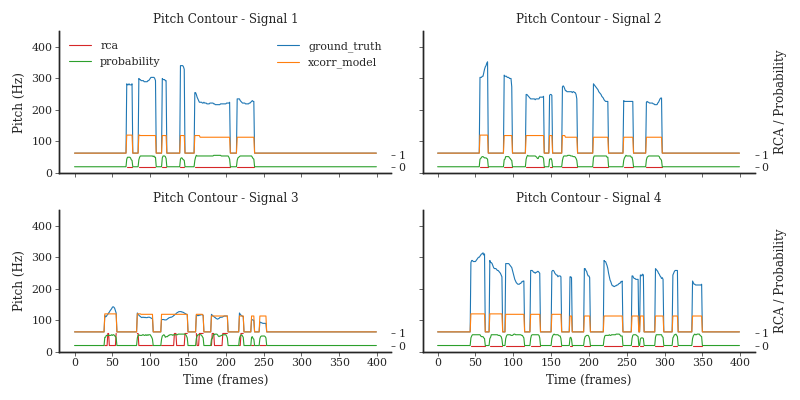

In [4]:
def plot_pitch_line_subplots(filename=None, **model_pitches):
    num_signals = len(list(model_pitches.values())[0])
    num_rows = num_signals // 2
    num_cols = (num_signals + 1) // 2  # Ensure enough columns to fit all subplots

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 2*num_rows), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        if i < num_signals:
            ax_rca = ax.twinx()

            ax.set_title(f'Pitch Contour - Signal {i + 1}')
            ax_rca.tick_params(axis='y')
            for model_name, pitches in model_pitches.items():
                if model_name in ['rca', 'probability']:
                    color = 'tab:red' if model_name == 'rca' else 'tab:green'
                    ax_rca.plot(pitches[i], label=model_name,color=color)
                    
                else:
                    ax.plot(pitches[i], label=model_name)
        if i == 0:
            ax.set_ylabel('Pitch (Hz)')
            ax.legend(loc='upper right')  
            ax_rca.legend(loc='upper left') 
        elif i==1:
            ax_rca.set_ylabel('RCA / Probability') 
        elif i == 2:
            ax.set_xlabel('Time (frames)')
            ax.set_ylabel('Pitch (Hz)')
        else:
            ax.set_xlabel('Time (frames)')
            ax_rca.set_ylabel('RCA / Probability')
        
             
        ax.set_ylim(0, 450)  
        ax_rca.set_ylim(-0.5, 11.25)  
        ax_rca.set_yticks(np.linspace(0, 1, 2))
        ax_rca.grid(False)
        ax.grid(False)
          

    plt.tight_layout()

    if filename:
        plt.savefig(filename, format='pdf')
    else:
        plt.show()

# Example usage
for key, eval_data in {'xcorr_model': pitches_predicted_fda}.items():
    pitches = eval_data * mask_gt
    pitches = torch.where(pitches == 0, torch.tensor(62.5), pitches)

    rca = RCAMetric(test_mode=True)
    out, mask = rca.compute_rca_per_frame(pitches, pitches_gt, probs_gt)
    metric = rca(pitches, pitches_gt, probs_gt)

    result = torch.where(out, torch.tensor(1.0), torch.tensor(0))
    result = torch.where(mask, result, torch.nan)
    torch.set_printoptions(threshold=None)

    print(f'RC Accuracy for {key}: {metric}')

    # Plotting each of the first 4 elements
    plot_pitch_line_subplots(ground_truth=pitches_gt, rca=result, **{key: eval_data}, probability=probs_gt, filename=f'pitch_contours_{key}_fda_with_lpc.pdf')
